In [2]:
# 2_Exploratory_Analysis.ipynb

# ===================================
# Step 1: Imports and Data Loading
# ===================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

# Load the cleaned orders dataset from GitHub
url_base = "https://raw.githubusercontent.com/zingeroff/Restaurant_Sales_Analysis/main/data"
orders_df = pd.read_csv(f"{url_base}/orders_cleaned.csv")

print("Data loaded. Shape:", orders_df.shape)
print(orders_df.head())
print("\nData Info:\n")
orders_df.info()


Data loaded. Shape: (150383, 9)
   order_id  client_id  order_date order_time  menu_item_id  quantity  \
0    900001       1126  2022-04-01   08:00:00           103         3   
1    900001       1126  2022-04-01   08:00:00           140         3   
2    900002       1594  2022-04-01   08:00:00           102         1   
3    900002       1594  2022-04-01   08:00:00           136         1   
4    900003       1864  2022-04-01   08:02:00           106         3   

   discount (%)  total_price ($) time_of_day  
0             0            38.97     Morning  
1             0             8.97     Morning  
2             0            13.50     Morning  
3             0             3.50     Morning  
4             0            32.97     Morning  

Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150383 entries, 0 to 150382
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   order_id         150383 n

In [5]:
# ===================================
# Step 2: Basic Stats
# ===================================

# Rename columns discount (%) and total_price ($) for better usability
orders_df.rename(
    columns={
        'discount (%)': 'discount',
        'total_price ($)': 'total_price'
    },
    inplace=True
)


unique_orders = orders_df['order_id'].nunique()
total_items = orders_df['quantity'].sum()
total_revenue = orders_df['total_price'].sum()

print(f"Unique orders: {unique_orders}")
print(f"Total items ordered: {total_items}")
print(f"Total revenue: ${total_revenue:,.2f}")

# Quick numeric summary
print("\nDescriptive Statistics:\n", orders_df[['quantity','total_price']].describe())


Unique orders: 66412
Total items ordered: 300170
Total revenue: $2,635,014.56

Descriptive Statistics:
             quantity    total_price
count  150383.000000  150383.000000
mean        1.996037      17.522024
std         0.815596      11.196170
min         1.000000       2.540000
25%         1.000000       8.970000
50%         2.000000      13.980000
75%         3.000000      25.500000
max         3.000000      44.970000


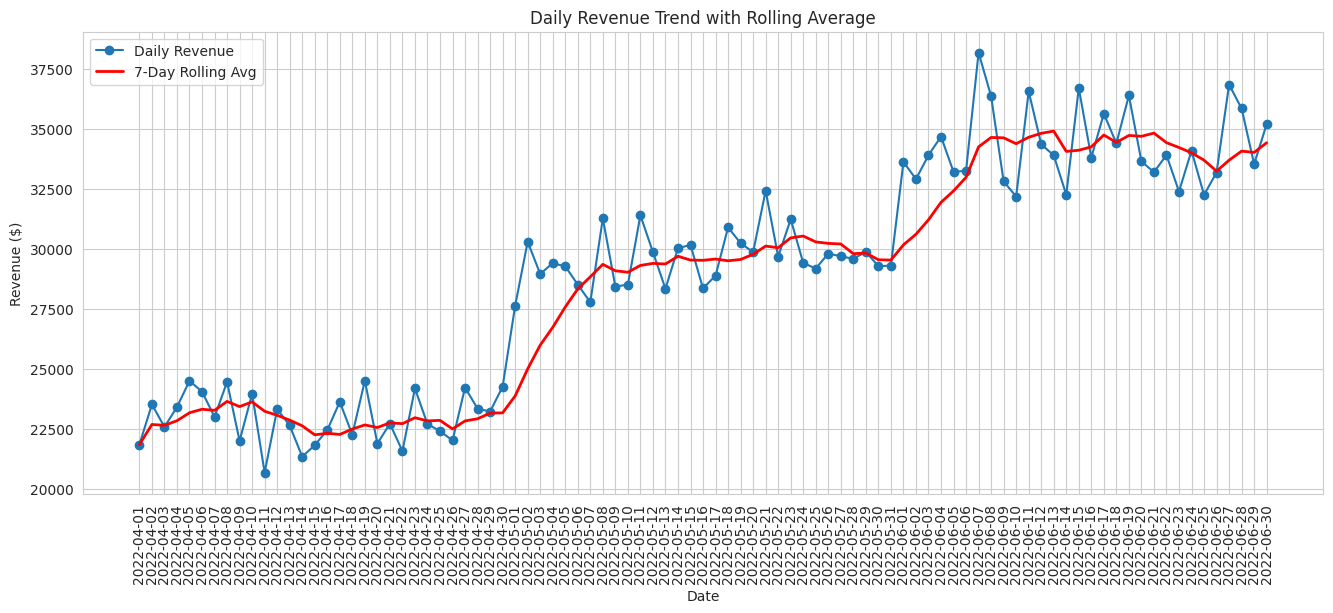

In [22]:
# ===================================
# Step 3A: Daily Revenue
# ===================================
daily_revenue = orders_df.groupby('order_date')['total_price'].sum().reset_index()

# daily_revenue: columns = ['order_date', 'total_price']
# Make sure it's sorted by date
daily_revenue = daily_revenue.sort_values('order_date')

# Calculate a 7-day rolling average
daily_revenue['rolling_7'] = daily_revenue['total_price'].rolling(window=7, min_periods=1).mean()

plt.figure(figsize=(16,6))

# Plot the raw daily revenue line
plt.plot(daily_revenue['order_date'], daily_revenue['total_price'], marker='o', label='Daily Revenue')

# Plot the rolling average
plt.plot(daily_revenue['order_date'], daily_revenue['rolling_7'], color='red', linewidth=2, label='7-Day Rolling Avg')

plt.title("Daily Revenue Trend with Rolling Average")
plt.xlabel("Date")
plt.ylabel("Revenue ($)")
plt.xticks(rotation=90)
plt.legend()
plt.show()



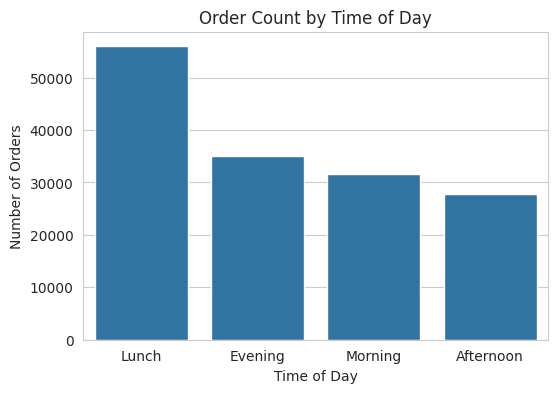

In [13]:
# ===================================
# Step 3B: Orders by Time of Day
# ===================================
time_of_day_counts = orders_df['time_of_day'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=time_of_day_counts.index, y=time_of_day_counts.values)
plt.title("Order Count by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Number of Orders")
plt.show()


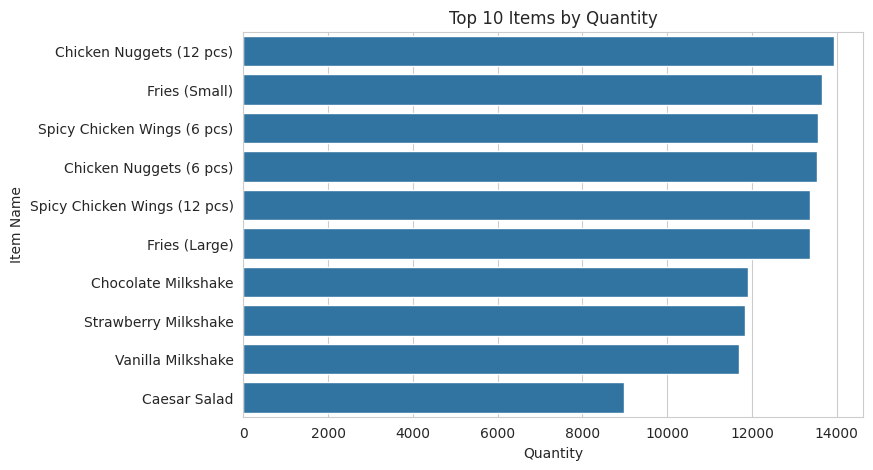

In [14]:
# ===================================
# Step 4: Top-Selling Items
# ===================================
url_menu = f"{url_base}/menu-data.csv"
menu_df = pd.read_csv(url_menu)

# Merge orders with menu to get item_name, category, price, etc.
merged_df = pd.merge(orders_df, menu_df, on='menu_item_id', how='left')

top_items = merged_df.groupby('item_name')[['quantity', 'total_price']].sum().reset_index()
top_items = top_items.sort_values(by='quantity', ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(data=top_items, x='quantity', y='item_name')
plt.title("Top 10 Items by Quantity")
plt.xlabel("Quantity")
plt.ylabel("Item Name")
plt.show()


Global AOV: $39.68


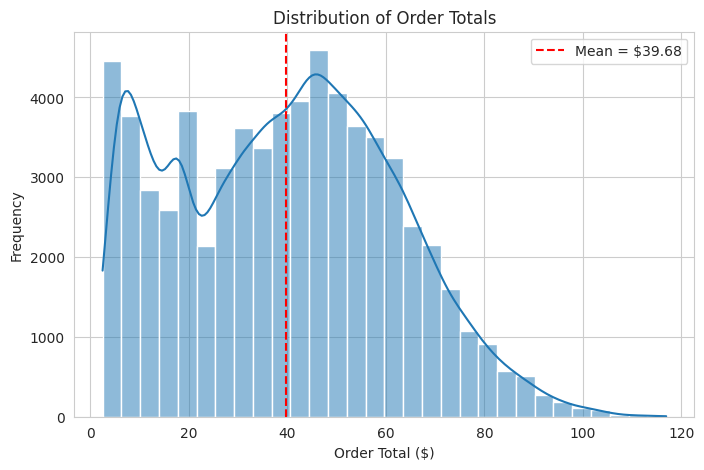

In [15]:
# ===================================
# Step 5A: Distribution of AOV
# ===================================

orders_grouped = orders_df.groupby('order_id')['total_price'].sum().reset_index()
orders_grouped.rename(columns={'total_price': 'order_total'}, inplace=True)

global_aov = orders_grouped['order_total'].mean()
print(f"Global AOV: ${global_aov:,.2f}")

plt.figure(figsize=(8,5))
sns.histplot(orders_grouped['order_total'], bins=30, kde=True)
plt.title("Distribution of Order Totals")
plt.xlabel("Order Total ($)")
plt.ylabel("Frequency")
plt.axvline(global_aov, color='red', linestyle='--', label=f"Mean = ${global_aov:,.2f}")
plt.legend()
plt.show()


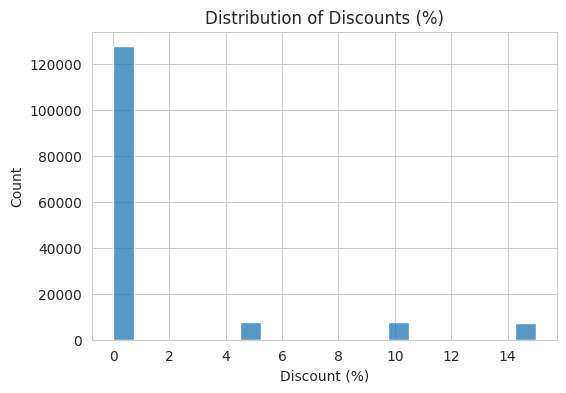

In [16]:
# ===================================
# Step 5B: Discount Distribution
# ===================================
if 'discount' in orders_df.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(orders_df['discount'], bins=20)
    plt.title("Distribution of Discounts (%)")
    plt.xlabel("Discount (%)")
    plt.ylabel("Count")
    plt.show()
else:
    print("No 'discount' column found.")


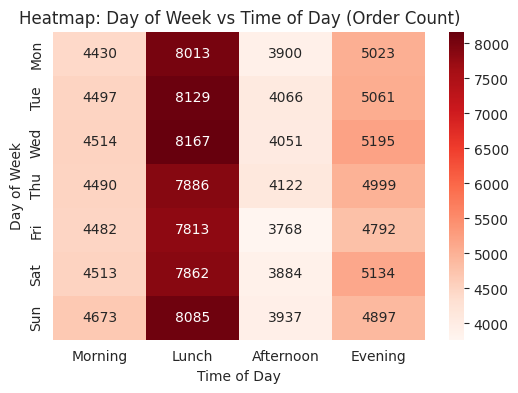

In [19]:
# ===================================
# Step 5C: Heatmap (Day of Week vs Time of Day)
# ===================================
import datetime

orders_df['day_of_week'] = pd.to_datetime(orders_df['order_date']).dt.dayofweek
day_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
orders_df['day_name'] = orders_df['day_of_week'].map(day_map)

pivot_data = orders_df.pivot_table(
    index='day_name',
    columns='time_of_day',
    values='order_id',
    aggfunc='count'
).fillna(0)

# Define the desired order for days of the week
days_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Define the desired order for time_of_day
time_of_day_order = ['Morning', 'Lunch', 'Afternoon', 'Evening']

# Reindex the pivot_data to enforce the order
pivot_data = pivot_data.reindex(index=days_order, columns=time_of_day_order)


plt.figure(figsize=(6,4))
sns.heatmap(pivot_data, cmap='Reds', annot=True, fmt='.0f')
plt.title("Heatmap: Day of Week vs Time of Day (Order Count)")
plt.xlabel("Time of Day")
plt.ylabel("Day of Week")
plt.show()


### Key Findings

1. **Daily Revenue Trend**: Visualization of revenue by day over three months demonstrates an upward trend in sales (in dollars). Day-to-day fluctuations in revenue are not significant.
2. **Time of Day**:The chart shows that the lunch period (11:00–14:00) has the highest number of orders, followed by the evening and morning periods, with the afternoon period having the lowest order count. This indicates that lunch is the peak time for customer activity, while the afternoon sees a significant drop in orders.
3. **Top-Selling Items**: Chicken Nuggets (12 pcs) are the most popular item, followed by Fries (Small) and Spicy Chicken Wings (6 pcs). Milkshakes and salads also rank among the top items, reflecting a diverse customer preference for snacks and beverages.
4. **AOV**: The distribution of order totals shows that the majority of orders fall in the range of $20 to $60, with a mean order total of $39.68. This suggests that customers tend to spend around this average amount per visit, indicating a balance between individual and group orders. Additionally, the long tail on the right side of the distribution highlights occasional high-value orders, likely influenced by larger group sizes or multiple items per order.
5. **Discount Usage**: The data shows that most customers do not use discounts. Orders without any discount make up the vast majority, while discounts of 5%, 10%, and 15% were used in only a small number of orders. This suggests that the discount program is not widely used by customers.
6. **Heatmap (Day of Week vs Time of Day)**: The heatmap reveals that Wednesday and Sunday have the highest order volumes during lunch hours, making them peak days for sales. In contrast, mornings and afternoons across all days see significantly lower order counts.

These insights guide management decisions for staffing, promotional timing, and menu optimization.
